In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

In [2]:
# Load data
df = pd.read_csv(r'C:\Users\vlogs\OneDrive\Desktop\Churn Prediction\Data\cleaned_churn_data.csv')


# Step 1: Prepare data
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split dataset (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [3]:
from sklearn.preprocessing import LabelEncoder

# Convert target if needed
if y_train.dtype == 'object':
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

# Convert categorical features in X_train/X_test to numeric (one-hot encoding)
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Align columns of test with train (in case dummies differ)
X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

# Check for missing values
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)


In [4]:
# Step 2: Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

# Step 3: Train XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]

c:\Users\vlogs\OneDrive\Desktop\Churn Prediction\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:21:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [5]:
# Step 4: Train LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
y_prob_lgb = lgb_model.predict_proba(X_test)[:,1]

# Step 5: Evaluate function
def evaluate_model(y_true, y_pred, y_prob, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)
    print(f"{model_name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"ROC-AUC: {roc:.4f}")
    print("-"*30)

# Step 6: Evaluate all
evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, y_prob_xgb, "XGBoost")
evaluate_model(y_test, y_pred_lgb, y_prob_lgb, "LightGBM")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265314 -> initscore=-1.018527
[LightGBM] [Info] Start training from score -1.018527
Random Forest Performance:
Accuracy: 0.7847
Precision: 0.6305
Recall: 0.4563
ROC-AUC: 0.8232
------------------------------
XGBoost Performance:
Accuracy: 0.7728
Precision: 0.5839
Recall: 0.5027
ROC-AUC: 0.8144
------------------------------
LightGBM Performance:
Accuracy: 0.7856
Precision: 0.6189
Recall: 0.5009
ROC-AUC: 0.8275
------------------------------


In [6]:
# Assuming X_train and X_test are defined from train_test_split

categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Convert target y_train and y_test if needed
from sklearn.preprocessing import LabelEncoder

if y_train.dtype == 'object':
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)


In [7]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.metrics import make_scorer, recall_score

# Define LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Define hyperparameter grid
param_dist = {
    'num_leaves': [20, 30, 40, 50, 60],          # Number of leaves in one tree
    'max_depth': [5, 10, 15, 20, -1],            # Max depth of tree, -1 means no limit
    'learning_rate': [0.01, 0.05, 0.1, 0.15],    # Step size shrinkage
    'n_estimators': [100, 200, 300, 400, 500],   # Number of boosting iterations
    'min_child_samples': [5, 10, 20, 30],        # Minimum data in one leaf
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],      # Bagging fraction
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]# Feature fraction
}

# Use recall as scoring metric because catching churners is priority
recall_scorer = make_scorer(recall_score)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=50,               # Number of parameter settings sampled
    scoring=recall_scorer,   # Optimize for recall
    cv=5,                   # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1               # Use all cores
)

# Run the search
random_search.fit(X_train_encoded, y_train)

# Best params and score
print("Best Recall Score:", random_search.best_score_)
print("Best Hyperparameters:", random_search.best_params_)

# Use the best estimator to predict on test
best_lgb = random_search.best_estimator_
y_pred_best = best_lgb.predict(X_test_encoded)
y_prob_best = best_lgb.predict_proba(X_test_encoded)[:, 1]

# Evaluate tuned model
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

print("Tuned LightGBM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_best):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_best):.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265314 -> initscore=-1.018527
[LightGBM] [Info] Start training from score -1.018527
Best Recall Score: 0.5329004708841508
Best Hyperparameters: {'subsample': 0.7, 'num_leaves': 30, 'n_estimators': 500, 'min_child_samples': 5, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Tuned LightGBM Performance:
Accuracy: 0.7960
Precision: 0.6464
Recall: 0.5116
ROC-AUC: 0.8353


c:\Users\vlogs\OneDrive\Desktop\Churn Prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\vlogs\OneDrive\Desktop\Churn Prediction\venv\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


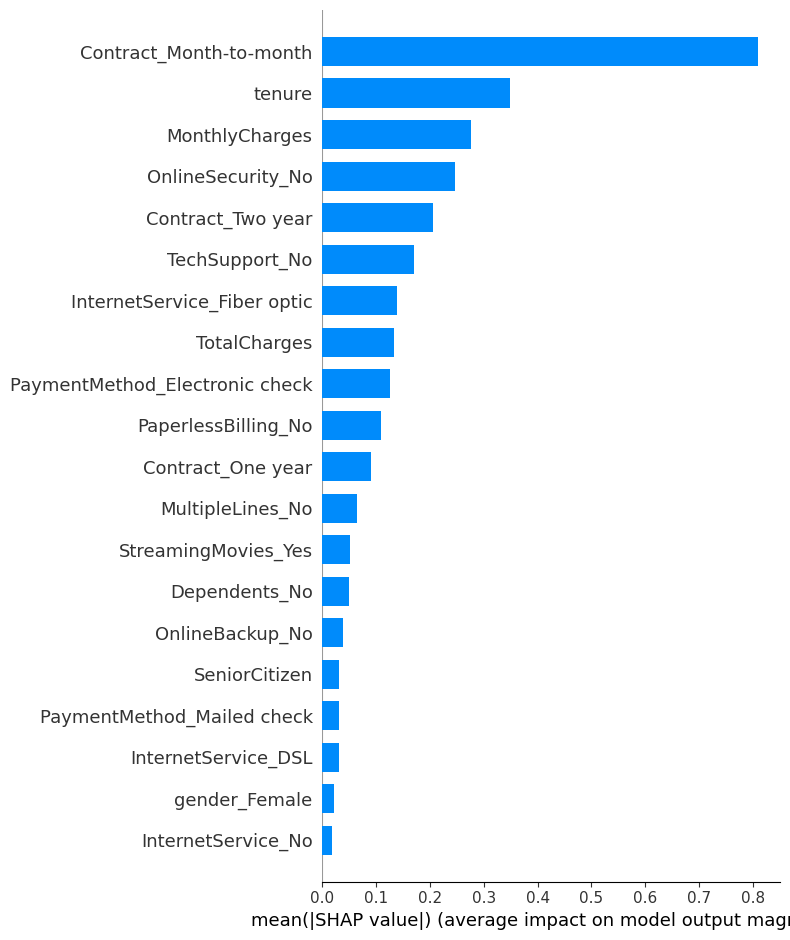

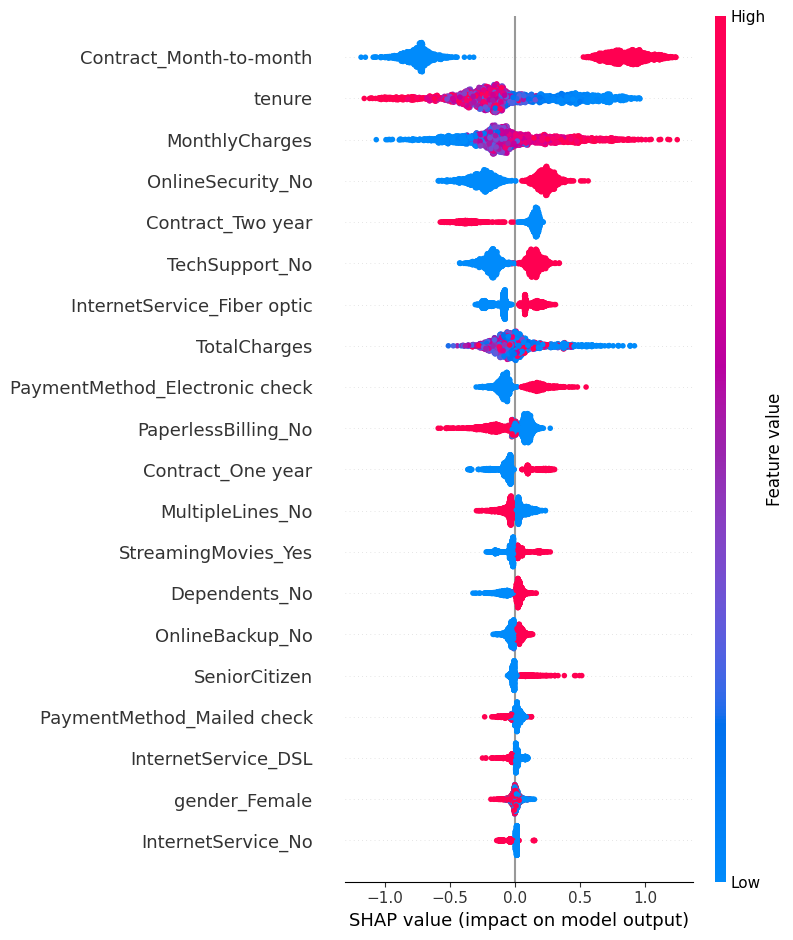

In [8]:
# SHAP 
# Why SHAP?
# Shows impact of each feature on model output — globally and for individual predictions. Transparent, additive, and consistent explanations.
# Helps uncover insights and builds trust in your model.

import shap

# Create SHAP explainer for LightGBM
explainer = shap.TreeExplainer(best_lgb)

# Calculate SHAP values for test set
shap_values = explainer.shap_values(X_test_encoded)

# Summary plot: global feature importance and effect
shap.summary_plot(shap_values, X_test_encoded, plot_type="bar")

# Detailed beeswarm plot for feature impact on individual predictions
shap.summary_plot(shap_values, X_test_encoded)

# (Optional) Force plot for a single prediction explanation
index = 0  # change index to explore other test samples
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[index], X_test_encoded.iloc[index])


In [9]:
from lightgbm import LGBMClassifier

# Initialize with tuned hyperparameters from your RandomizedSearchCV or manual tuning
best_lgb = LGBMClassifier(
    learning_rate=0.01,
    max_depth=20,
    min_child_samples=5,
    n_estimators=500,
    num_leaves=30,
    subsample=0.7,
    colsample_bytree=1.0,
    random_state=42
)

# Fit the model on your encoded training data
best_lgb.fit(X_train_encoded, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265314 -> initscore=-1.018527
[LightGBM] [Info] Start training from score -1.018527


,boosting_type,'gbdt'
,num_leaves,30
,max_depth,20
,learning_rate,0.01
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,5


In [10]:
import pickle

with open("best_lgb_model.pkl", "wb") as f:
    pickle.dump(best_lgb, f)

print("Model saved successfully!")


Model saved successfully!


In [12]:
from sklearn.preprocessing import OneHotEncoder

# Load training data frame if needed
# df = pd.read_csv("cleaned_churn_data.csv")

# Define categorical columns again (cleaned)
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
            'PaperlessBilling', 'PaymentMethod']

# Fit OneHotEncoder
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoder.fit(df[cat_cols])

print("Encoder fitted successfully!")


Encoder fitted successfully!


In [16]:
import pickle

# 1. Save encoder
with open("encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)


# 2. Save encoded feature names
# After you encode your train data:
feature_names = X_train_encoded.columns.tolist()  # or model.feature_name_

with open("feature_names.pkl", "wb") as f:
    pickle.dump(feature_names, f)


# 3. Save categorical column list
with open("cat_cols.pkl", "wb") as f:
    pickle.dump(cat_cols, f)

print("encoder.pkl, feature_names.pkl, and cat_cols.pkl created successfully!")


encoder.pkl, feature_names.pkl, and cat_cols.pkl created successfully!
